# Kernel Quadratures


**resources**

* [Doc](https://docs.google.com/document/d/1ZdYyq2q22FhzW_4KuZU6Mp8Pccg5sUGH6v3QZxo8b2E/edit)

In [1]:
import sys, os
from pyprojroot import here
from wandb.sdk import wandb_config

# spyder up to find the root
root = here(project_files=[".here", ".env"])
# append to path
sys.path.append(str(root))

%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
# from pathlib import Path

# print(Path.cwd(), root)

## Toy Data

In [3]:
import jax
import jax.random as jr
import jax.numpy as jnp

seed = 123
key = jr.PRNGKey(seed)

ntrain = 60
ntest = 1_000

f = lambda x: jnp.sin(1.0 * jnp.pi / 1.6 * jnp.cos(5 + 0.5 * x))

X = jnp.linspace(-10, 10, ntrain).reshape(-1, 1)
X_cov = jnp.array([0.1]).reshape(-1, 1)

key, y_rng = jr.split(key, 2)
y = f(X)


Xtest = jnp.linspace(-10.1, 10.1, ntest).reshape(-1, 1)

## GP Model

In [4]:
from gpjax.gps import Prior
from gpjax.mean_functions import Zero
from gpjax.kernels import RBF
from gpjax.likelihoods import Gaussian
from gpjax.types import Dataset
from gpjax.parameters import initialise

In [5]:
# GP Prior
mean_function = Zero()
kernel = RBF()
prior = Prior(mean_function=mean_function, kernel=kernel)

# GP Likelihood
lik = Gaussian()

# GP Posterior
posterior = prior * lik

# initialize training dataset
training_ds = Dataset(X=X, y=y)

In [6]:
# initialize parameters
params = initialise(posterior)

params = {"obs_noise": 0.003321, "lengthscale": 1.849, "variance": 0.9014}

## Predictions

In [7]:
from gpjax import mean, variance

meanf = mean(posterior, params, training_ds)
covarf = variance(posterior, params, training_ds)
varf = lambda x: jnp.atleast_1d(jnp.diag(covarf(x)))


mu = meanf(Xtest).squeeze()
var = varf(Xtest).squeeze()

In [8]:
n_features = 1


xtest_sample = Xtest[0]
xtrain_sample = X[0]

xtest_sample = jnp.atleast_1d(xtest_sample)
xtrain_sample = jnp.atleast_1d(xtrain_sample)

### Moment Transform

In [9]:
from jaxkern.gp.uncertain.mcmc import MCMomentTransform
from jaxkern.gp.uncertain.unscented import UnscentedTransform, SphericalRadialTransform
from jaxkern.gp.uncertain.quadrature import GaussHermite

# mm_transform = MCMomentTransform(n_features=1, n_samples=1_000, seed=123)
# mm_transform = UnscentedTransform(n_features=1, alpha=1.0, beta=2.0, kappa=None)
# mm_transform = GaussHermite(n_features=1, degree=20)
mm_transform = SphericalRadialTransform(n_features=1)

## Mean Expectations

In [10]:
from typing import Callable, Dict
import chex
from jaxkern.kernels.expectations import e_Mx, e_Kx, e_Kxy

In [11]:
# initialize function
f = e_Mx(meanf, mm_transform,)

y_mu = f(xtest_sample, X_cov)


chex.assert_shape(y_mu, (n_features,))

In [12]:
f = e_Mx(meanf, mm_transform,)


f = jax.jit(jax.vmap(f, in_axes=(0, None)))

In [13]:
%%time

y_mu = f( Xtest.block_until_ready(), X_cov.block_until_ready())

chex.assert_shape(y_mu, (ntest, n_features,))

CPU times: user 84.5 ms, sys: 4 ms, total: 88.5 ms
Wall time: 84.4 ms


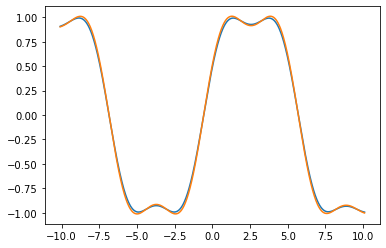

In [14]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.plot(Xtest, y_mu)
plt.plot(Xtest, mu)

## Mean Prediction


$$
\tilde{\boldsymbol{\mu}}_{MMGP}(\mathbf{x_*}) = \Psi_1^\top\alpha 
$$

In [15]:
from jaxkern.gp.predictive import moment_matching_mean

In [16]:
mm_mean_f = moment_matching_mean(posterior, params, training_ds, mm_transform)

In [17]:
y_mm_mu = mm_mean_f(Xtest, X_cov)

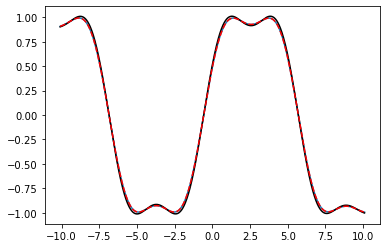

In [18]:
%matplotlib inline

plt.plot(Xtest, y_mu)
plt.plot(Xtest, mu, color="black")
plt.plot(Xtest, y_mm_mu, linestyle="--", color="red")

## Predictive Variance Function


$$
\tilde{\mathbf{\Sigma}}^2_{MMGP}(\mathbf{x}_*)
=
\psi_0 - \text{Tr}\left( \left(\mathbf{K}_{GP}^{-1}  - \alpha\alpha^\top\right) \Psi_2\right) - \text{Tr}\left( \Psi_1\Psi_1^\top\alpha\alpha^\top \right),
$$

In [26]:
from gpjax.gps import ConjugatePosterior
from chex import dataclass, Array
from gpjax.kernels import gram
from gpjax.utils import I
from jax.scipy.linalg import cho_factor, cho_solve
from jaxkern.kernels.expectations import e_Mx, e_Kx, e_Kxy, e_Kxy_Kxz


def moment_matching_variance(
    gp: ConjugatePosterior,
    param: dict,
    training: Dataset,
    mm_transform: dataclass,
    obs_noise: bool = True,
) -> Callable:
    X, y = training.X, training.y
    sigma = param["obs_noise"]
    n_train = training.n
    Kff = gram(gp.prior.kernel, X, param)
    Kinv = jnp.linalg.inv(Kff + I(n_train) * sigma)
    L = cho_factor(Kff + I(n_train) * sigma, lower=True)
    prior_mean = gp.prior.mean_function(X)
    prior_distance = y - prior_mean
    weights = cho_solve(L, prior_distance)

    if obs_noise:
        noise_constant = sigma
    else:
        noise_constant = 1.0

    # Term 1, vectorized
    term1 = e_Kx(gp.prior.kernel, param, mm_transform=mm_transform)
    psi0 = jax.vmap(term1, in_axes=(0, None))

    # Term 2, vectorized
    term2 = e_Kxy(gp.prior.kernel, param, mm_transform=mm_transform)

    mv = jax.vmap(term2, in_axes=(0, None, None), out_axes=(0))
    psi1 = jax.vmap(mv, in_axes=(None, None, 0), out_axes=(1))

    # Term 3, vectorized
    term3 = e_Kxy_Kxz(
        gp.prior.kernel, param, gp.prior.kernel, param, mm_transform=mm_transform
    )
    mvv = jax.vmap(term3, in_axes=(0, None, None, None), out_axes=(0))
    mmv = jax.vmap(mvv, in_axes=(None, None, 0, None), out_axes=(1))
    psi2 = jax.vmap(mmv, in_axes=(None, None, None, 0), out_axes=(2))

    def varf(test_inputs: Array, test_cov: Array) -> Array:

        # term 1
        t1 = psi0(test_inputs, test_cov)[..., 0]

        # term 2
        t2 = Kinv - weights @ weights.T
        t2 = t2 @ psi2(test_inputs, test_cov, X, X)[..., 0]
        t2 = jnp.trace(t2, axis1=1, axis2=2)

        # Term 3
        t3 = psi1(test_inputs, test_cov, X)[..., 0] @ weights
        t3 = t3 ** 2

        return t1.squeeze() - t2.squeeze() - t3.squeeze() + noise_constant

    return varf

In [27]:
mm_mean_f = moment_matching_mean(posterior, params, training_ds, mm_transform)
mm_var_f = moment_matching_variance(posterior, params, training_ds, mm_transform)
y_mm_mu = mm_mean_f(Xtest, X_cov).squeeze()
y_mm_var = mm_var_f(Xtest, X_cov).squeeze()

y_mm_std = 1.96 * jnp.sqrt(y_mm_var).squeeze()

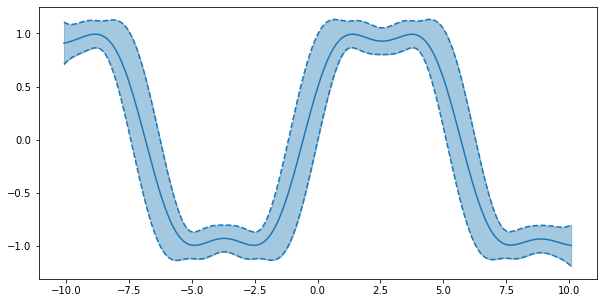

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(Xtest, y_mm_mu.squeeze() - y_mm_std.squeeze(), linestyle="--", color="tab:blue")
ax.fill_between(
    Xtest.ravel(),
    y_mm_mu.ravel() - y_mm_std,
    y_mm_mu.ravel() + y_mm_std,
    alpha=0.4,
    color="tab:blue",
)
ax.plot(Xtest, y_mm_mu.squeeze())
ax.plot(Xtest, y_mm_mu.squeeze() + y_mm_std.squeeze(), linestyle="--", color="tab:blue")